In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
base_dir = 'tire_textures'
train_dir = os.path.join(base_dir, 'training_data')
val_dir = os.path.join(base_dir, 'validation_data')
test_dir = os.path.join(base_dir, 'testing_data')

In [15]:
# Parâmetros
img_width, img_height = 224, 224  # Tamanho de entrada esperado pelo VGG16
batch_size = 32

In [16]:
# Criação dos ImageDataGenerators para treino, validação e teste
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Gerador para treinamento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # classificação binária: cracked vs normal
)

# Gerador para validação
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Gerador para teste
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=1,      # Para avaliação, processamos uma imagem por vez
    class_mode='binary',
    shuffle=False
)

Found 687 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


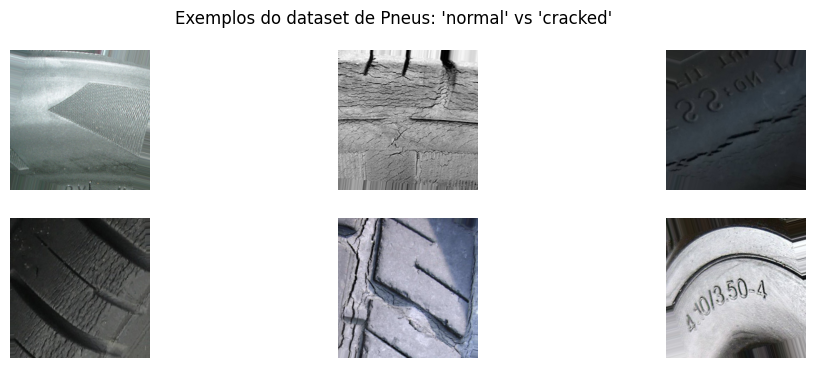

In [17]:
# Exibição de alguns exemplos do dataset
import random
sample_imgs, _ = next(train_generator)
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_imgs[i])
    plt.axis('off')
plt.suptitle("Exemplos do dataset de Pneus: 'normal' vs 'cracked'")
plt.show()

In [18]:
# Construção da arquitetura utilizando transferência de aprendizado com VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Congela as camadas do VGG16
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Adiciona camadas customizadas para a classificação binária
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # saída para classificação binária

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
# Treinamento do modelo
epochs = 12
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4971 - loss: 0.7615 - val_accuracy: 0.5625 - val_loss: 0.6519
Epoch 2/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4375 - loss: 0.7876 - val_accuracy: 0.5625 - val_loss: 0.6497
Epoch 3/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5651 - loss: 0.6994 - val_accuracy: 0.8125 - val_loss: 0.6019
Epoch 4/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6250 - loss: 0.6413 - val_accuracy: 0.8125 - val_loss: 0.5991
Epoch 5/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5999 - loss: 0.6793 - val_accuracy: 0.9375 - val_loss: 0.5565
Epoch 6/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.6875 - loss: 0.5862 - val_accuracy: 0.9375 - val_loss: 0.5547
Epoch 7/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6764 - loss: 0.5998 - val_accuracy: 0.9375 - val_loss: 0.5214
Epoch 8/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7500 - loss: 0.5148 - val_accuracy: 0.9375 - val_l

In [24]:
# Salvando o modelo nos formatos HDF5 e no formato keras (SavedModel)
model.save('modelo_tires.h5')
model.save('modelo_tires.keras')

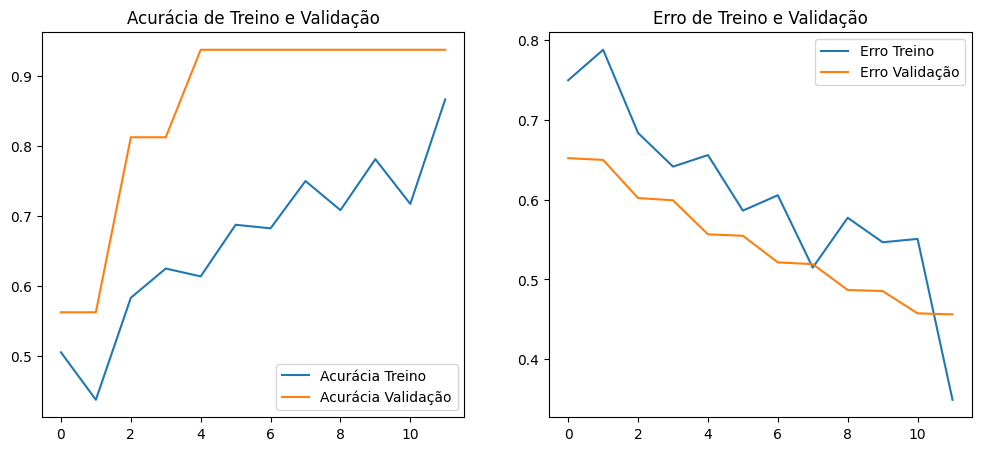

In [25]:
# Plotando as curvas de treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia Treino')
plt.plot(epochs_range, val_acc, label='Acurácia Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro Treino')
plt.plot(epochs_range, val_loss, label='Erro Validação')
plt.legend(loc='upper right')
plt.title('Erro de Treino e Validação')
plt.show()

In [26]:
# Avaliação do modelo no conjunto de teste
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples)
# Como usamos ativação sigmoide, limiaramos a probabilidade em 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Extraindo as classes reais
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Imprime o relatório de classificação
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Relatório de Classificação:\n", report)

325/325 ━━━━━━━━━━━━━━━━━━━━ 53s 163ms/step
Relatório de Classificação:
               precision    recall  f1-score   support

     cracked       0.99      0.36      0.52       210
      normal       0.46      0.99      0.63       115

    accuracy                           0.58       325
   macro avg       0.72      0.67      0.58       325
weighted avg       0.80      0.58      0.56       325

